In [1]:
'''This script demonstrates VAE on image data

 #Reference
 - Jointly Trained Variational Autoencoder for Multi-Modal Sensor Fusion https://ieeexplore.ieee.org/document/9011314
 - rubiks-dataset https://github.com/tik0/rubiks-dataset
'''

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
import tensorflow.keras as keras
import vae_tools.loader as loader

import vae_tools
from vae_tools import plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer

Configure and load the data

In [2]:
# noinspection JupyterKernel,JupyterKernel,JupyterKernel
epochs = 1000           # Training steps 
target_size = (30, 40) # Image size

# Load the data
action_train, v1_train, v2_train, cube_states, cube_colors = loader.rubiks(num_tuples = int(10000), target_size = (30, 40), working_dir = '/tmp')

Cmd('git') failed due to: exit code(128)
  cmdline: git clone https://github.com/tik0/rubiks-dataset.git
  stderr: 'fatal: destination path 'rubiks-dataset' already exists and is not an empty directory.'
Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 29 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 49 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


Configure and build the MMVAE

In [3]:
# Define the MMVAE

# input image dimensions and config
batch_size = 128
action_dim = 3
image_rows_cols_chns = (target_size[0], target_size[1], 3)
original_dim = np.prod(image_rows_cols_chns)
latent_dim = 2
intermediate_dim = 256 # former 128
intermediate_dim_2 = int(intermediate_dim / 2)
save_model = False
#beta = 0.012207031 # 50.
beta = 1.

X_train_s1 = v1_train
X_train_s2 = v2_train
X_train_actions = action_train

# Reshape the data
# X_train = X_train.reshape(len(X_train),np.prod(X_train.shape[1:]))
X_train_s1_flatten = X_train_s1.reshape((X_train_s1.shape[0], np.prod(X_train_s1.shape[1:])))
X_train_s2_flatten = X_train_s2.reshape((X_train_s2.shape[0], np.prod(X_train_s2.shape[1:])))
# Add the action to the first modality
X_train_s1_flatten = np.concatenate((X_train_s1_flatten,X_train_actions), axis = 1)

# Define encoder and decoder
e1_1 = Input(shape=(original_dim + action_dim,))
e1_2 = Input(shape=(original_dim,))
e2_1 = Dense(intermediate_dim, activation='relu')
e2_2 = Dense(intermediate_dim, activation='relu')
e3_1 = Dense(intermediate_dim_2, activation='relu')
e3_2 = Dense(intermediate_dim_2, activation='relu')
encoder = [[e1_1, e2_1, e3_1], [e1_2, e2_2, e3_2]]
d1_1 = Dense(intermediate_dim_2, activation='relu')
d2_1 = Dense(intermediate_dim, activation='relu')
d3_1 = Dense(original_dim + action_dim, activation='sigmoid')
d1_2 = Dense(intermediate_dim_2, activation='relu')
d2_2 = Dense(intermediate_dim, activation='relu')
d3_2 = Dense(original_dim, activation='sigmoid')
decoder = [[d1_1, d2_1, d3_1], [d1_2, d2_2, d3_2]]

latent_encoder = Dense(intermediate_dim, activation='relu', name="lat_enc")
latent_encoder.is_relative = [False]
latent_encoder.layer_dimensions = [intermediate_dim]
latent_encoder.activations = ['relu']
model_obj = vae_tools.mmvae.MmVae(latent_dim, encoder, decoder, [original_dim + action_dim, original_dim],
                                  beta, beta_is_normalized = False, reconstruction_loss_metrics = [vae_tools.mmvae.ReconstructionLoss.MSE],
                                  latent_encoder = latent_encoder,
                                  name='mmvae')
vae = model_obj.get_model()
vae.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [5]:
# Train

h = vae.fit([X_train_s1_flatten, X_train_s2_flatten],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 0)


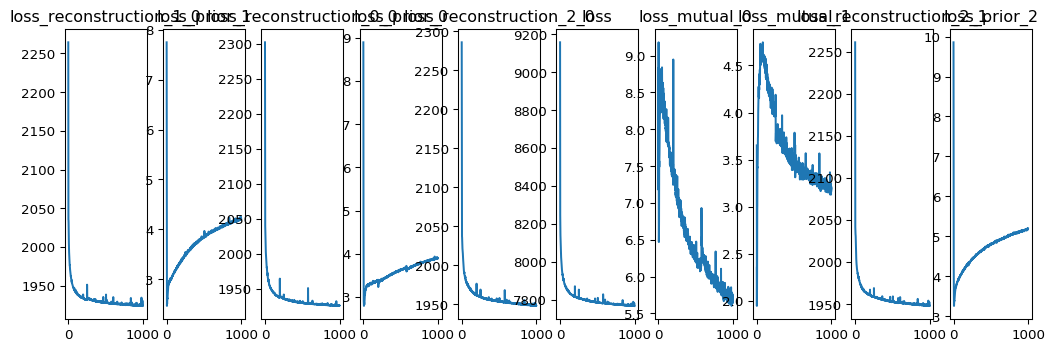

In [6]:
# Plot the losses

num_losses = len(h.history.keys())
f, ax = plt.subplots(1,num_losses, figsize=(13,4), dpi=96)
for k, idx in zip(h.history.keys(), range(num_losses)):
    ax[idx].plot(h.history[k])
    ax[idx].set_title(k)
plt.show()

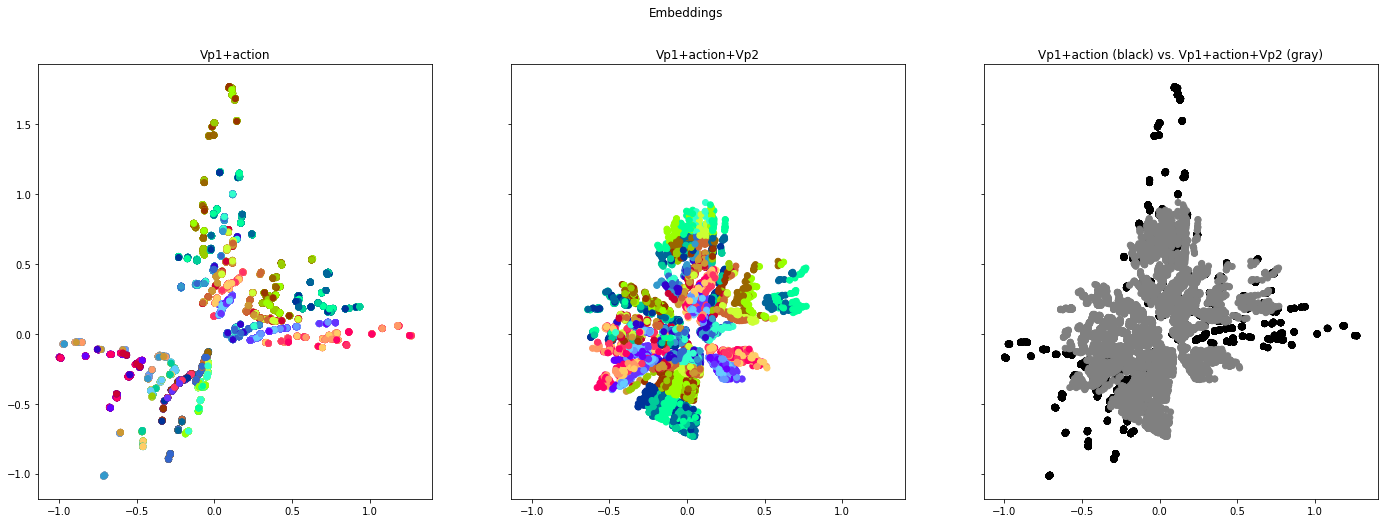

In [7]:
# Plot the latent embeddings

f, axs = plt.subplots(1,3, figsize = [24, 8], sharex=True, sharey=True)

# Check the output distribution of the feature extractor.
# The colors of the positions [left, front, right] define the state of the cube.
# If the plot shows pure colored clusters, then the MMVAE found the hidden state of the cube
c_cube_states = []
for left, front, right in zip(cube_states['left'], cube_states['front'], cube_states['right']):
    c_cube_states.append([cube_colors.index(left), cube_colors.index(front), cube_colors.index(right)])
c_cube_states = np.asarray(c_cube_states)/np.max(c_cube_states)
#X_train_flatten = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))

# Embedding of the Vp1 + action
# This should predict the viewpoint2 sufficiently in the case where left and right is observed)
# In all other cases (eg. front->right, left->front, ..., the cube's state cannot be resolved)
X_train_feat_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
axs[0].scatter(X_train_feat_uni[:,0], X_train_feat_uni[:,1], c=c_cube_states)
axs[0].set_title("Vp1+action")

# Show the embedding Vp1+action+Vp2 which should show clear clusters
X_train_feat_bi = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
axs[1].scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=c_cube_states)
axs[1].set_title("Vp1+action+Vp2")

# Show the embedding Vp1+action (black) and Vp1+action+Vp2 (gray) in one plot
# to see where information was added
axs[2].scatter(X_train_feat_uni[:,0], X_train_feat_uni[:,1], c=np.tile(np.asarray([0.,0.,0.]), (X_train_feat_uni.shape[0],1)))
axs[2].scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=np.tile(np.asarray([.5,.5,.5]), (X_train_feat_bi.shape[0],1)))
axs[2].set_title("Vp1+action (black) vs. Vp1+action+Vp2 (gray)")
plt.suptitle("Embeddings")
plt.show()


[[0.  1.  0.5]]
[[-0.07241908  0.29431316]]


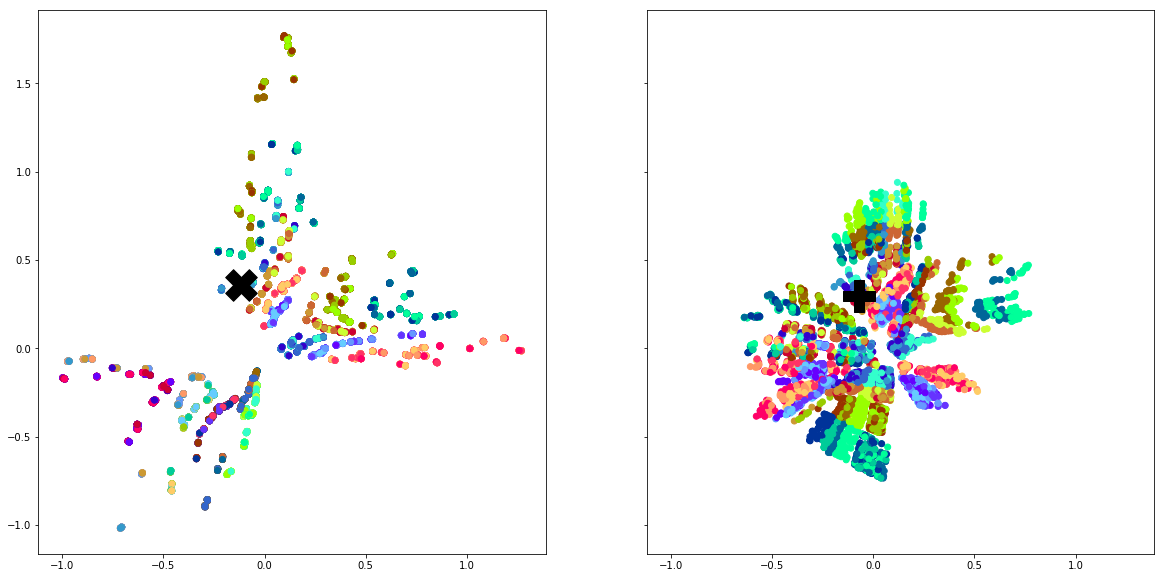

In [27]:
# Show transition from Vp1+action to Vp1+action+Vp2

# Hypothesis
# left/right => We should stay at least in the same cluster, because the VAE should predict the other view
# front/right => Switch cluster, because the VAE can not predict the right from front view
# front/left => Switch cluster, because the VAE can not predict the left from front view
# right/left => We should stay at least in the same cluster, because the VAE should predict the other view
# right/front => Switch cluster, because the VAE can not predict the front from right view
# left/front => Switch cluster, because the VAE can not predict the front from left view

# left to right 
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,2] == 1.))[0]
# left to front
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,1] == 1.))[0]
# right to front
idx = np.argwhere((action_train[:,2] == 0.5) * (action_train[:,1] == 1.))[0]

f, axs = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

axs[0].scatter(X_train_feat_uni[:,0], X_train_feat_uni[:,1], c=c_cube_states)
axs[1].scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=c_cube_states)
axs[0].scatter(X_train_feat_uni[idx,0], X_train_feat_uni[idx,1], c=[[.0,.0,.0]], s=1000, marker='X',linewidths=1)
axs[1].scatter(X_train_feat_bi[idx,0], X_train_feat_bi[idx,1], c=[[.0,.0,.0]], s=1000, marker='P',linewidths=1)
#plt.xlim([-.5, -.3])
#plt.ylim([-.1, .1])
plt.show()

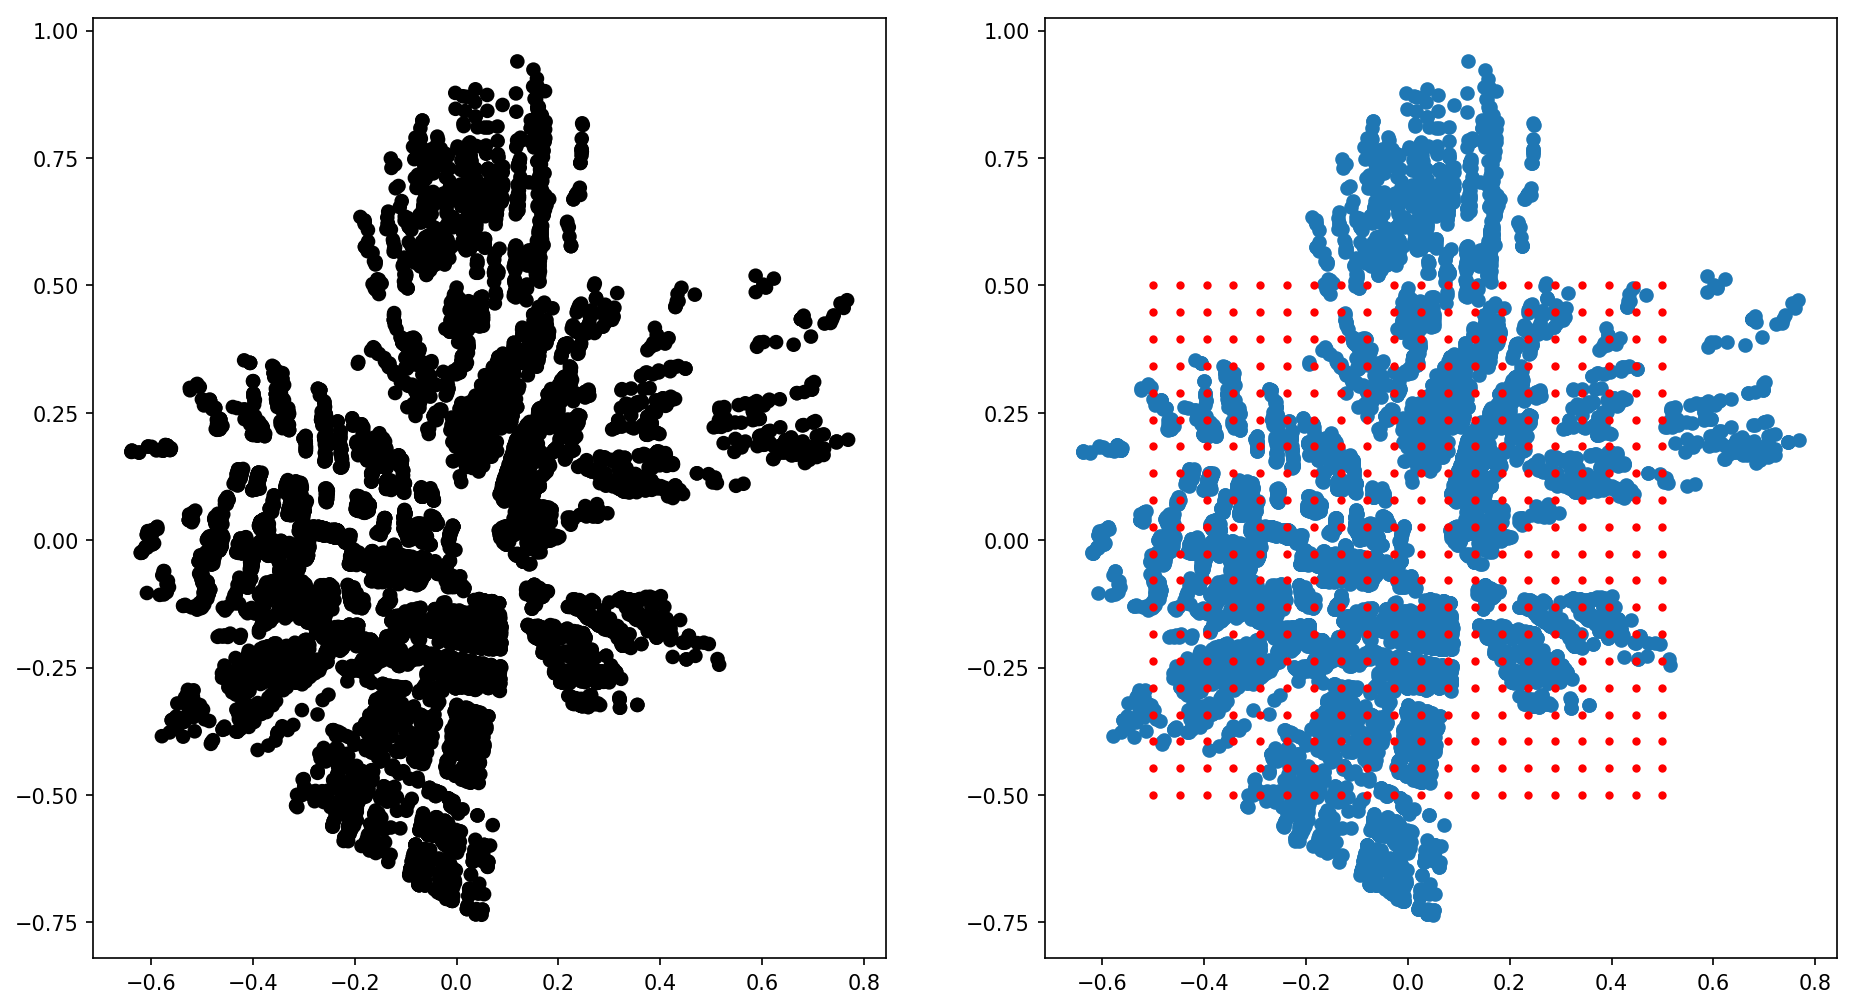

/opt/repositories/vae_tools/vae_tools/viz.py:129: UserWarning: Output of decoder is not reshapable into size image_rows_cols_chns (num_val_image=3600 != num_val_decoder=3603). Will truncate values.
  warnings.warn("Output of decoder is not reshapable into size image_rows_cols_chns (num_val_image=" + str(num_val_image) + " != num_val_decoder=" + str(num_val_decoder) + "). Will truncate values.")


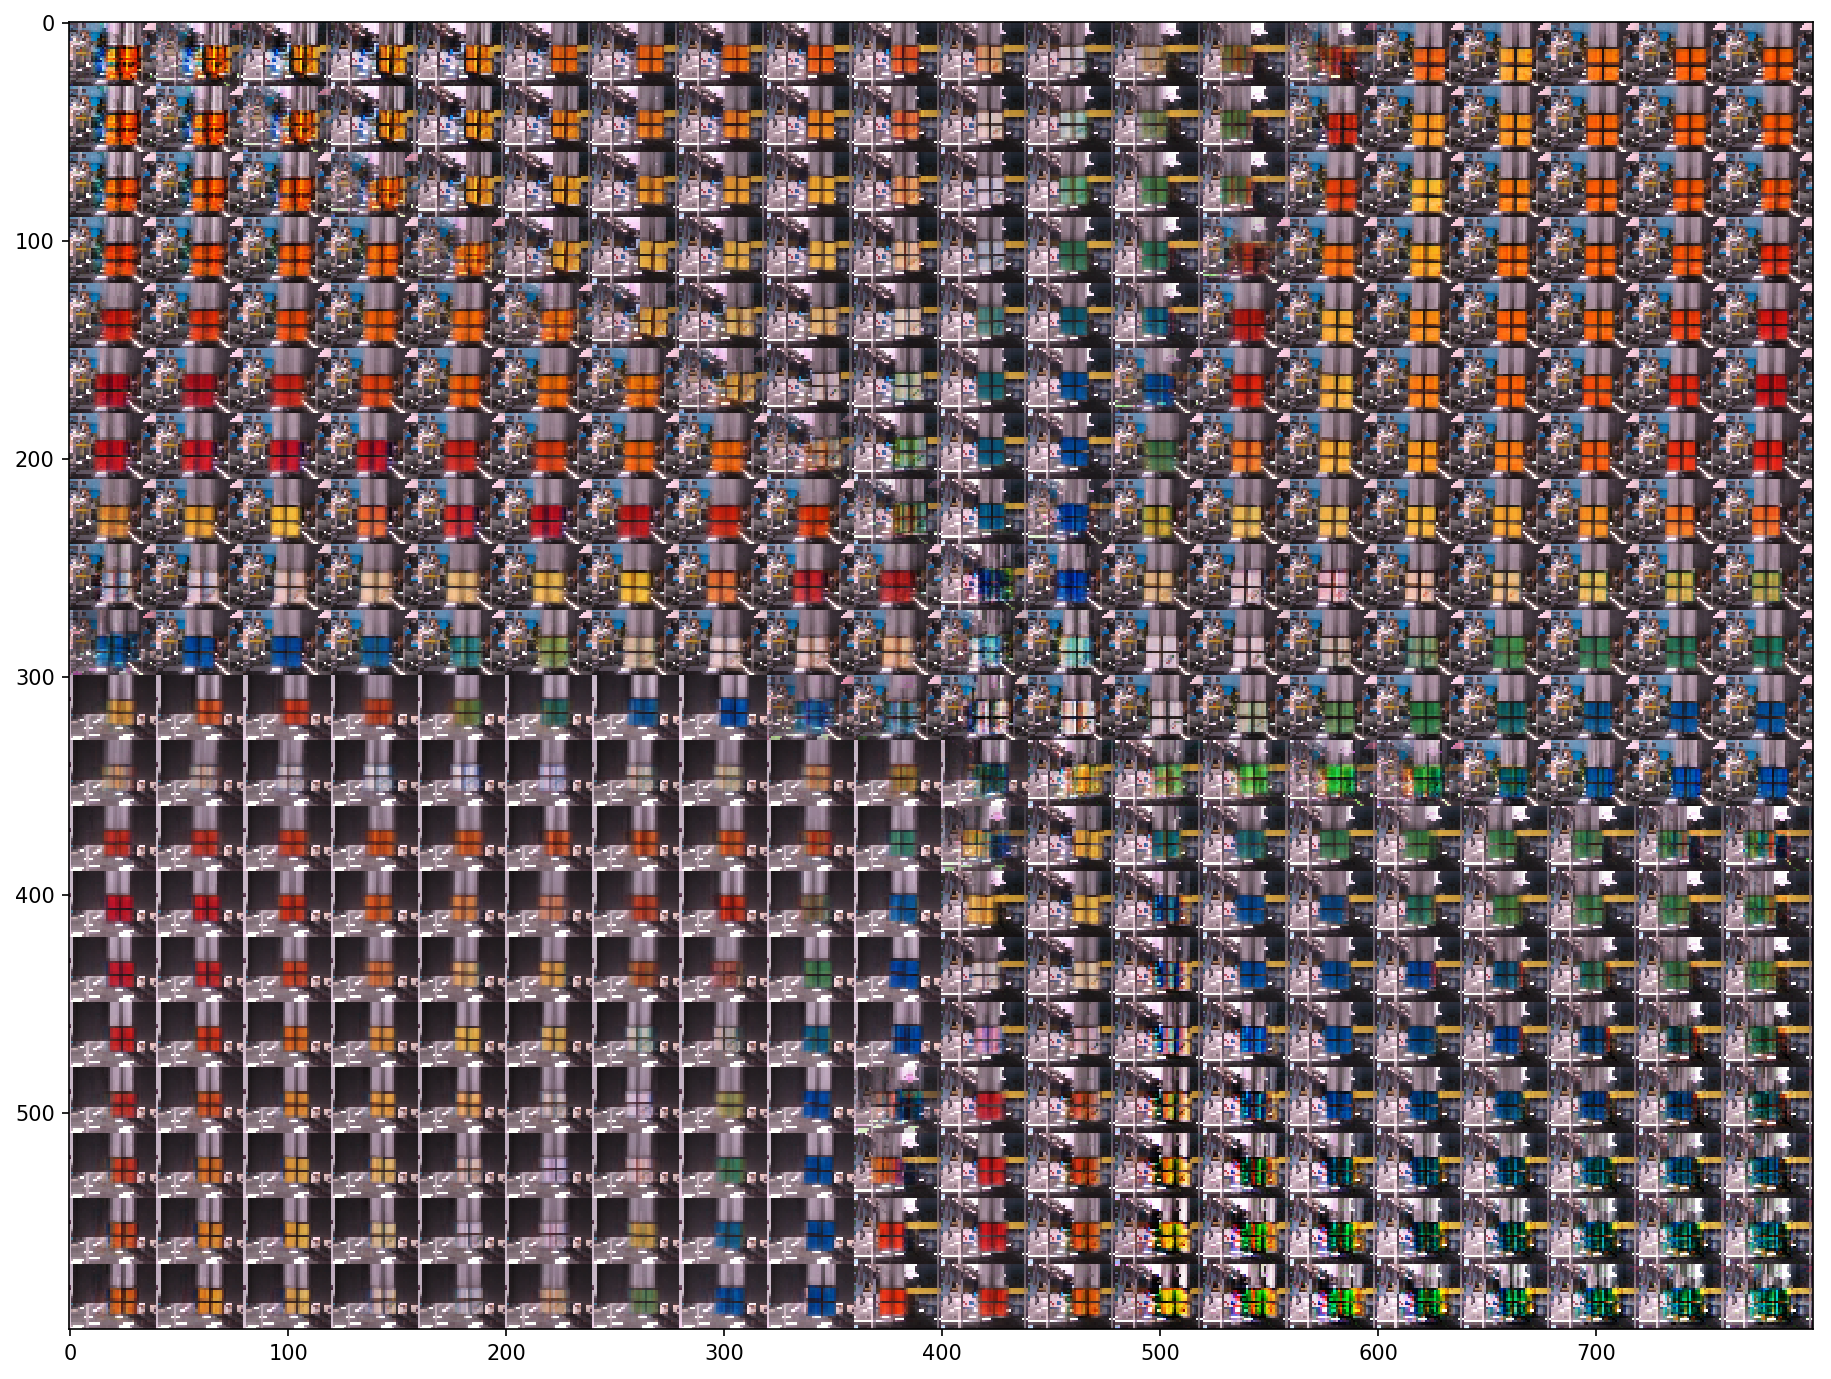

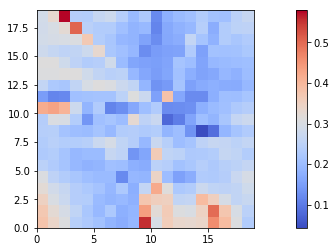

In [15]:
# Sampling from the latent space
# Encode samples to get the min and max values in latent space
#x_test_encoded = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)

# display a 2D manifold
nx = 20
ny = 20

## linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
## to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.1, 0.9, nx))
grid_y = norm.ppf(np.linspace(0.1, 0.9, ny))
grid_x = np.linspace(-.5, .5, nx)
grid_y = np.linspace(-.5, .5, ny)
#grid_x = np.linspace(np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0]), nx)
#grid_y = np.linspace(np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1]), ny)

# display a 2D plot of the digit classes in the latent space
import vae_tools
from importlib import reload  # Python 3.4+ only.
viz = reload(vae_tools.viz)
#vae_tools.viz.scatter_encoder([X_train_s1_flatten, X_train_s2_flatten], np.zeros((len(X_train_s1_flatten),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)
vae_tools.viz.scatter_encoder_2([X_train_s1_flatten, X_train_s2_flatten],
                  np.zeros((len(X_train_s1_flatten),3)),
                  grid_x, grid_y,
                  model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]),
                  figsize=(15, 15), dpi=150)
#vae_tools.viz.scatter_encoder(X_train, np.zeros((len(X_train),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)

# Plot the resampled inputs
#figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples(grid_x, grid_y, model_obj, image_rows_cols_chns)
#figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples_2(grid_x, grid_y, encoder_mean, encoder_log_var, decoder, 2, image_rows_cols_chns)
encoder_mean = model_obj.get_encoder_mean([encoder[0][0]])
encoder_log_var = model_obj.get_encoder_logvar([encoder[0][0]])
decoder_model = model_obj.get_decoder(decoder_output_list = [decoder[0][-1]])
figure, z_reencoded_mean, z_reencoded_std = viz.get_image_dec_enc_samples_2(grid_x, grid_y, encoder_mean, encoder_log_var, decoder_model, 2, image_rows_cols_chns)
plt.figure(figsize=(15, 15), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, z_reencoded_std, cmap='coolwarm', vmin=z_reencoded_std.min(), vmax=z_reencoded_std.max())
plt.colorbar()
plt.axis("image")
plt.show()

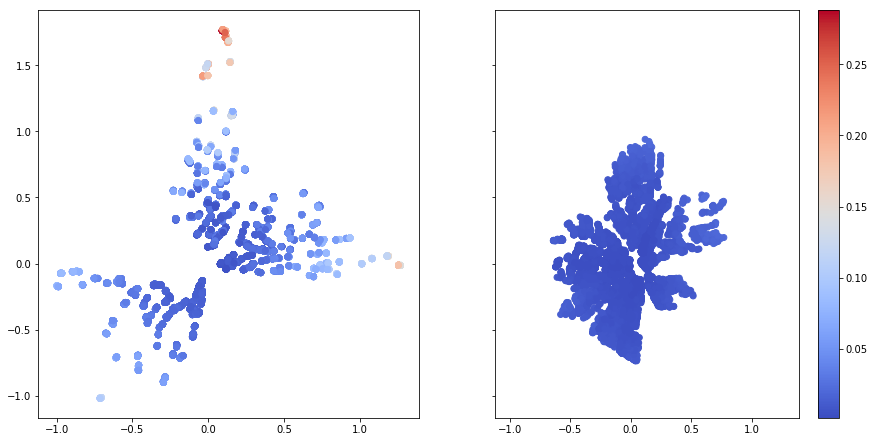

In [10]:
# Plot the resampled std deviations
#X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
x_encoded_mean_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_logvar_uni = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_mean_bi = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
x_encoded_logvar_bi = model_obj.get_encoder_logvar([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
x_encoded_logvar_viz_uni = np.sum(np.exp(x_encoded_logvar_uni), axis = 1)
x_encoded_logvar_viz_bi = np.sum(np.exp(x_encoded_logvar_bi), axis = 1)
val_min = np.concatenate((x_encoded_logvar_viz_uni, x_encoded_logvar_viz_bi), axis = 0).min()
val_max = np.concatenate((x_encoded_logvar_viz_uni, x_encoded_logvar_viz_bi), axis = 0).max()

f, axs = plt.subplots(1,2, figsize=(15, 7.5), sharex=True, sharey=True)

# Uni
cmap = 'coolwarm'
axs[0].scatter(x_encoded_mean_uni[:,0], x_encoded_mean_uni[:,1], c=x_encoded_logvar_viz_uni, cmap=cmap, vmin=val_min, vmax=val_max)
#plt.colorbar()
#plt.axis("image")
#plt.show()

# Bi
p = axs[1].scatter(x_encoded_mean_bi[:,0], x_encoded_mean_bi[:,1], c=x_encoded_logvar_viz_bi, cmap=cmap, vmin=val_min, vmax=val_max)
f.colorbar(p, ax=axs[1])
#plt.axis("image")
plt.show()

In [11]:
# Print the resampled std deviations (choose one index)
# left to right 
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,2] == 1.))[0]
# left to front
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,1] == 1.))[0]
# right to front
idx = np.argwhere((action_train[:,2] == 0.5) * (action_train[:,1] == 1.))[0]

x_encoded_mean_uni_1 = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_logvar_uni_1 = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_mean_uni_2 = model_obj.get_encoder_mean([encoder[1][0]]).predict(X_train_s2_flatten)
x_encoded_logvar_uni_2 = model_obj.get_encoder_logvar([encoder[1][0]]).predict(X_train_s2_flatten)
x_encoded_mean_bi_ = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
x_encoded_logvar_bi_ = model_obj.get_encoder_logvar([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])

# Uni
x_encoded_logvar_viz_uni_1 = np.sum(np.exp(x_encoded_logvar_uni_1), axis = 1)
x_encoded_logvar_viz_uni_2 = np.sum(np.exp(x_encoded_logvar_uni_2), axis = 1)

print("x_encoded_logvar_viz_uni_1: ", x_encoded_logvar_viz_uni_1[idx])
print("x_encoded_logvar_viz_uni_2: ", x_encoded_logvar_viz_uni_2[idx])
# Bi
x_encoded_logvar_viz_bi_ = np.sum(np.exp(x_encoded_logvar_bi_), axis = 1)
print("x_encoded_logvar_viz_bi_:   ", x_encoded_logvar_viz_bi_[idx])

[1.  0.5 0. ]
[ 0.00394893 -0.14508781]
x_encoded_logvar_viz_uni_1:  0.014776137
x_encoded_logvar_viz_uni_2:  0.005216767
x_encoded_logvar_viz_bi_:    0.003052405


In [26]:
x_dkl_uni_1 = vae_tools.metrics.kl_loss_n(x_encoded_mean_uni_1, x_encoded_logvar_uni_1)
x_dkl_uni_2 = vae_tools.metrics.kl_loss_n(x_encoded_mean_uni_2, x_encoded_logvar_uni_2)
x_dkl_bi    = vae_tools.metrics.kl_loss_n(x_encoded_mean_bi, x_encoded_logvar_bi)
x_dkl_uni_1_to_bi = vae_tools.metrics.kl_loss(x_encoded_mean_uni_1, x_encoded_mean_bi, x_encoded_logvar_uni_1, x_encoded_logvar_bi)

print("\nVariance of left/right views")
mask = (action_train[:,0] > 0.) * (action_train[:,2] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of left/right views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of left vs left/right views")
print("mean: ", np.mean(x_dkl_uni_1_to_bi[mask]))
print("var: ", np.var(x_dkl_uni_1_to_bi[mask]))

print("\nVariance of left/front and right/front views")
print(np.mean(x_encoded_logvar_viz_uni_1[~mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[~mask]))
print(np.mean(x_encoded_logvar_viz_bi_[~mask]))
print("DKL of left/front and right/front views")
print(np.mean(x_dkl_uni_1[~mask]))
print(np.mean(x_dkl_uni_2[~mask]))
print(np.mean(x_dkl_bi[~mask]))
print("DKL of left vs left/front and right vs right/front views")
print("mean: ", np.mean(x_dkl_uni_1_to_bi[~mask]))
print("var:  ", np.var(x_dkl_uni_1_to_bi[~mask]))

print("\nVariance of left/front views")
mask = (action_train[:,0] > 0.) * (action_train[:,1] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of left/front views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of left vs left/front")
print("mean: ", np.mean(x_dkl_uni_1_to_bi[mask]))
print("var:  ", np.var(x_dkl_uni_1_to_bi[mask]))

print("\nVariance of right/front views")
mask = (action_train[:,2] > 0.) * (action_train[:,1] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of right/front views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of right vs right/front")
print("mean: ", np.mean(x_dkl_uni_1_to_bi[mask]))
print("var:  ", np.var(x_dkl_uni_1_to_bi[mask]))


Variance of left/right views
0.055560403
0.013728921
0.004705996
DKL of left/right views
1.7713649
2.2380424
2.6347575
DKL of left vs left/right views
79.2859

Variance of left/front and right/front views
0.029786773
0.021346139
0.005688488
DKL of left/front and right/front views
1.9589382
2.0384815
2.5855532
DKL of left vs left/front and right vs right/front views
25.508633

Variance of left/front views
0.028029818
0.023470609
0.0056291088
DKL of left/front views
1.9398968
2.0083873
2.5789936
DKL of left vs left/front
mean:  27.128664
var:   7600.147

Variance of right/front views
0.031488452
0.019288516
0.0057459986
DKL of right/front views
1.9773808
2.0676286
2.5919068
DKL of right vs right/front
23.939573


In [30]:
model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten[[idx]])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([[-0.11794585,  0.3605253 ]], dtype=float32)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


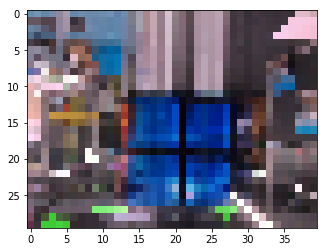

In [33]:
# Let's see how good the prediction works

# left to right
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,2] == 1.))[0]
# left to front
idx = np.argwhere((action_train[:,0] == 0.5) * (action_train[:,1] == 1.))[0]
# right to front
#idx = np.argwhere((action_train[:,2] == 0.5) * (action_train[:,1] == 1.))[0]

X_train_feat_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten[[idx]])

#model_obj.get_decoder(decoder_output_list = [decoder[0][-1]])
X_train_feat_uni_decoded = model_obj.get_decoder().predict(np.asarray(X_train_feat_uni))
plt.imshow(X_train_feat_uni_decoded[1].reshape((target_size[0], target_size[1],3)))
plt.show()


TypeError: Invalid dimensions for image data

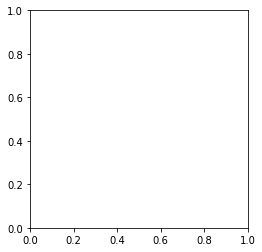